# Описание проекта

Необходимо проанализировать данные сервиса продажи самокатов GoFast.Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверем некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
без подписки
абонентская плата отсутствует;
стоимость одной минуты поездки — 
8
8 рублей;
стоимость старта (начала поездки) — 
50
50 рублей;
с подпиской Ultra
абонентская плата — 
199
199 рублей в месяц;
стоимость одной минуты поездки — 
6
6 рублей;
стоимость старта — бесплатно.

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [5]:
users = pd.read_csv('/datasets/users_go.csv')
display(users)
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


user_id	уникальный идентификатор пользователя
name	имя пользователя
age	возраст
city	город
subscription_type	тип подписки (free, ultra)
Все данные готовы к анализу. Пропусков нет. Типы данных правильные. Необходимо проверить на дуюликаты колонку user_id. Данные в ней предполагаются уникальные. 

In [6]:
rides = pd.read_csv('/datasets/rides_go.csv')
display(rides)
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


user_id	уникальный идентификатор пользователя
distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
date	дата совершения поездки
Предварительный анализ показывает, что данные без пропусков. Дубликатов здесь нет, т.к. нет столбца, требующего уникальных данных.
Необходимо преобразовать тип данных столбца "date"

In [7]:
subs = pd.read_csv('/datasets/subscriptions_go.csv')
display(subs)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


subscription_type	тип подписки
minute_price	стоимость одной минуты поездки по данной подписке
start_ride_price	стоимость начала поездки
subscription_fee	стоимость ежемесячного платежа
В данной таблице указаны ценовые параметры для подписчиков сервиса и без подписки.

#### Шаг 2. Предобработка данных

Преобразуем столбец с датой к правильному формату

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Добавим столбец с номером месяца

In [9]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
display(rides)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


проверим и удалим дубликаты из user_id. По смыслу это унимкальный столбец 

Пропусков в наших таблицах нет. Проверить на наличие дубликатов имеет смысл 'user_id'

In [10]:
users['user_id'].duplicated().sum()
users = users.drop_duplicates(subset='user_id',keep='first')
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


<div class="alert alert-info">В данном разделе провели предобработку данных. Привели дату к нужному формату. Удалили дубликаты. Проверили на наличие пропусков. </div>

### Исследовательский анализ данных

### Частота встречаемости городов

In [11]:
city_counts = users['city'].value_counts()

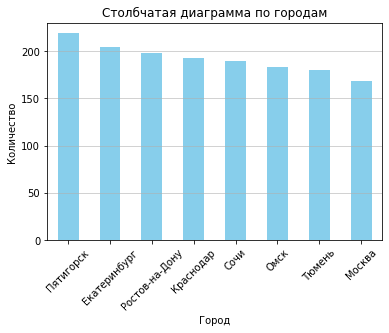

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


In [12]:
city_counts.plot(kind='bar', rot=45, color='skyblue')
plt.xlabel('Город')
plt.ylabel('Количество')
plt.title('Столбчатая диаграмма по городам')
plt.grid(axis='y', alpha=0.7)
plt.show()
print (city_counts)

Довольно ровное распределение пользователей сервиса по городам

In [13]:
subscr_counts = users['subscription_type'].value_counts()

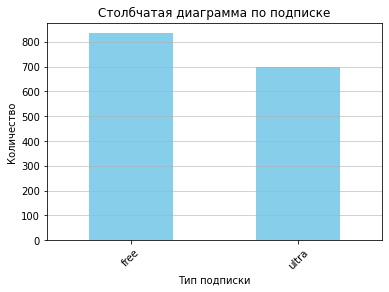

In [14]:
subscr_counts.plot(kind='bar', rot=45, color='skyblue')
plt.xlabel('Тип подписки')
plt.ylabel('Количество')
plt.title('Столбчатая диаграмма по подписке')
plt.grid(axis='y', alpha=0.7)
plt.show()

Число пользователей без подписки незначительно превышает пользователей с подпиской.

([<matplotlib.patches.Wedge at 0x7f8f3891a9d0>,
 [Text(1.089350532812134, -0.15269386582937716, 'free'),
  Text(-1.0893505185158978, 0.15269396782173414, 'ultra')],
 [Text(0.5941911997157094, -0.08328756317966025, '54.4%'),
  Text(-0.5941911919177624, 0.08328761881185497, '45.6%')])

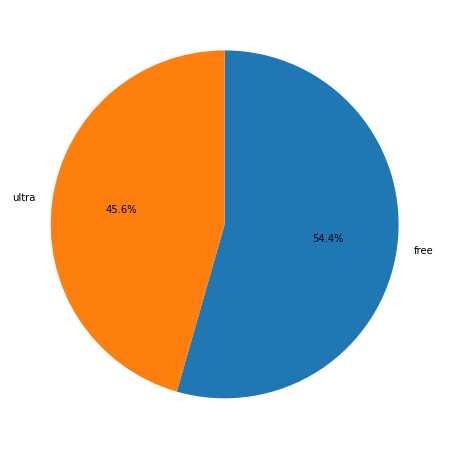

In [15]:
plt.figure(figsize=(8,8))
plt.pie(subscr_counts, labels=subscr_counts.index, autopct='%1.1f%%', startangle=90,counterclock=False)

In [16]:
print(subscr_counts)

free     835
ultra    699
Name: subscription_type, dtype: int64


In [17]:
age_counts = users['age'].value_counts()

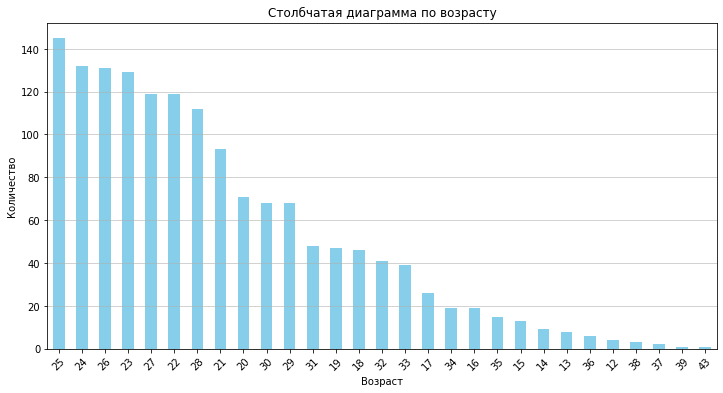

In [18]:
age_counts.plot(kind='bar', rot=45, color='skyblue', figsize=(12,6))
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Столбчатая диаграмма по возрасту')
plt.grid(axis='y', alpha=0.7)
plt.show()

In [19]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Сервис максимально востребован среди людей 20-30 лет

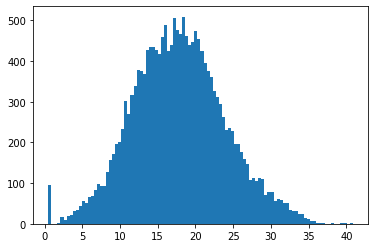

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [20]:
plt.hist(rides['duration'],bins=100)
plt.show()
rides['duration'].describe()

Довольно ровное распределение, близкое к нормальному. Явных выбросов нет. За исключением небольшого в районе 0. Что предположительно связано либо с неисправностью, либо то, что не понравилось. Медиана очень близка к средней 17.8 мин 

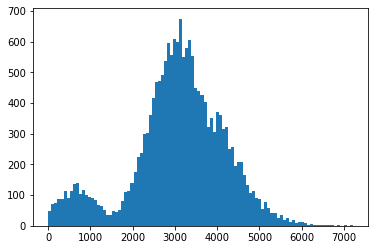

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [21]:
plt.hist(rides['distance'],bins=100)
plt.show()
rides['distance'].describe()

По дистанции все выводы схожи за исключением одного момента. Явно прослеживается 2 пика. До 1км и в районе 3км. Очевидно это связано с разными целями поездок - покататься в парке и в качестве транспорта добраться до нужного адреса. Средняя поездка около 3км

#### Шаг 4. Объединение данных

Объкдиним все 3 датасета в один для удобства анализа

In [22]:
merge_data = pd.merge(users, rides, on='user_id', how='inner')
merged_data = pd.merge(merge_data, subs, on='subscription_type', how='inner')
display(merged_data)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


<div class="alert alert-info">Округлим данные по продолжительности каждой поездки в большую сторону. </div>

In [23]:
merged_data['duration'] = np.ceil(merged_data['duration'])
display (merged_data)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


<div class="alert alert-info"> Округлим данные по длительности каждой поездки в большую сторону. </div>

In [24]:
merged_data['distance'] = np.ceil(merged_data['distance'])
display (merged_data)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,755.0,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3782.0,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2841.0,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3827.0,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2903.0,17.0,2021-11-27,11,8,50,0


Также создадим раздельные датасеты для пользователей с подпиской и без

In [25]:
merged_data_free = merged_data[merged_data['subscription_type']=='free']
display(merged_data_free)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2516.0,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,847.0,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4005.0,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1206.0,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3048.0,18.0,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3782.0,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2841.0,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3827.0,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2903.0,17.0,2021-11-27,11,8,50,0


In [26]:
merged_data_ultra = merged_data[merged_data['subscription_type']=='ultra']
display(merged_data_ultra)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,755.0,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3974.0,25.0,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3289.0,16.0,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3077.0,15.0,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4708.0,16.0,2021-10-17,10,6,0,199


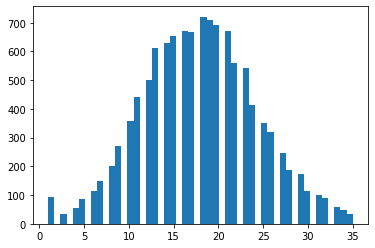

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [28]:
plt.hist(merged_data_free['duration'],bins=50)
plt.show()
merged_data_free['duration'].describe()

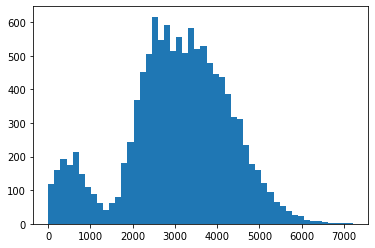

count    11568.000000
mean      3045.992911
std       1246.174341
min          1.000000
25%       2367.000000
50%       3115.000000
75%       3906.000000
max       7212.000000
Name: distance, dtype: float64

In [29]:
plt.hist(merged_data_free['distance'],bins=50)
plt.show()
merged_data_free['distance'].describe()

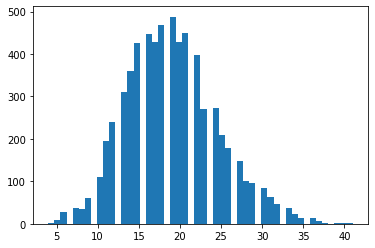

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

In [30]:
plt.hist(merged_data_ultra['duration'],bins=50)
plt.show()
merged_data_ultra['duration'].describe()

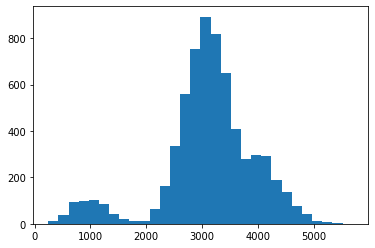

count    6500.000000
mean     3115.949231
std       836.894838
min       245.000000
25%      2786.000000
50%      3149.000000
75%      3561.000000
max      5700.000000
Name: distance, dtype: float64

In [31]:
plt.hist(merged_data_ultra['distance'],bins=30)
plt.show()
merged_data_ultra['distance'].describe()

Довольно неожиданно, что у подписчиков также есть локальный пик в районе 1000м. Я полагал, что подписчики используют самокат как транспорт. но возможно, они также катаются в парке на малое расстояние. При этом у пользователей без подписки явный локальный максимум на 300-500м. Что свидетельствует, что им просто не понравилось или не получилось.

Средняя дистанция у подписчиков - 3148. Что превышает оптимальное расстояние с т.зрения износа. Но крайне незначительо (менее 1% разница). При этом медиана в 3115м укладывается в нужный предел. С учетом, что у неподписчиков и средняя(3114) и медиана(3045) ниже нужного предела,можно уверенно говорить, что самокаты используются рационально.  

#### Шаг 5. Подсчёт выручки

1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [32]:
pivot_table_result = merged_data.pivot_table(index=['user_id','month']
      , values=['distance', 'duration'],
      aggfunc={'distance' : ['count','sum'],'duration':'sum'}  
    )
pivot_table_result = pivot_table_result.reset_index(drop=False)
display(pivot_table_result)
pivot_table_result.info()

user_id month distance          duration
                       count      sum      sum
0           1     1        2   7028.0     42.0
1           1     4        1    755.0      7.0
2           1     8        2   6724.0     46.0
3           1    10        2   5811.0     32.0
4           1    11        3   7005.0     56.0
...       ...   ...      ...      ...      ...
11326    1534     6        2   3411.0     26.0
11327    1534     8        2   7623.0     48.0
11328    1534     9        1   4929.0     23.0
11329    1534    11        4  13353.0     78.0
11330    1534    12        1   2372.0     16.0

[11331 rows x 5 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (user_id, )        11331 non-null  int64  
 1   (month, )          11331 non-null  int64  
 2   (distance, count)  11331 non-null  int64  
 3   (distance, sum)    11331 non-null  float64
 4   (duration, sum)    11331 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 442.7 KB


Получилась сводная таблица. Необходимо переименовать стобцы для дальнейшей работы.

In [33]:
pivot_table_result.columns = ['_'.join(col).strip()for col in pivot_table_result.columns.values]

In [34]:
pivot_table_result['duration_sum'] = np.ceil(pivot_table_result['duration_sum'])
pivot_table_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id_        11331 non-null  int64  
 1   month_          11331 non-null  int64  
 2   distance_count  11331 non-null  int64  
 3   distance_sum    11331 non-null  float64
 4   duration_sum    11331 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 442.7 KB


In [35]:
pivot_table_result = pivot_table_result.rename(columns={'user_id_':'user_id', 'month_':'month'})
display (pivot_table_result)

,user_id,month,distance_count,distance_sum,duration_sum
0,1,1,2,7028.0,42.0
1,1,4,1,755.0,7.0
2,1,8,2,6724.0,46.0
3,1,10,2,5811.0,32.0
4,1,11,3,7005.0,56.0
...,...,...,...,...,...
11326,1534,6,2,3411.0,26.0
11327,1534,8,2,7623.0,48.0
11328,1534,9,1,4929.0,23.0
11329,1534,11,4,13353.0,78.0


In [36]:
result_new = pd.merge(pivot_table_result, users[['user_id', 'subscription_type']],on='user_id', how='left')
display(result_new)

,user_id,month,distance_count,distance_sum,duration_sum,subscription_type
0,1,1,2,7028.0,42.0,ultra
1,1,4,1,755.0,7.0,ultra
2,1,8,2,6724.0,46.0,ultra
3,1,10,2,5811.0,32.0,ultra
4,1,11,3,7005.0,56.0,ultra
...,...,...,...,...,...,...
11326,1534,6,2,3411.0,26.0,free
11327,1534,8,2,7623.0,48.0,free
11328,1534,9,1,4929.0,23.0,free
11329,1534,11,4,13353.0,78.0,free


Создадим функцию для расчета выручки по каждому пользователю. Алгоритм расчета несколько отличается для подписчиков и нет. Данные по стоимости подписки вставлены напрямую в формулу. Что неправильно, т.к. могут поменяться в исходном датасете. Но так сделано для простоты, т.к. всего 4 числа.  

In [37]:
def calc_income(row):
    if row['subscription_type']=='ultra':
        return \
            row['distance_count']*0 + row['duration_sum']*6 + 199
    elif row['subscription_type']=='free':
        return row['distance_count']*50 + row['duration_sum']*8 + 0
    else:
        return 0

Добавим столбец с выручкой по каждому пользователю в месяц.

In [38]:
result_new['income'] = result_new.apply(calc_income,axis=1)
display(result_new)

,user_id,month,distance_count,distance_sum,duration_sum,subscription_type,income
0,1,1,2,7028.0,42.0,ultra,451.0
1,1,4,1,755.0,7.0,ultra,241.0
2,1,8,2,6724.0,46.0,ultra,475.0
3,1,10,2,5811.0,32.0,ultra,391.0
4,1,11,3,7005.0,56.0,ultra,535.0
...,...,...,...,...,...,...,...
11326,1534,6,2,3411.0,26.0,free,308.0
11327,1534,8,2,7623.0,48.0,free,484.0
11328,1534,9,1,4929.0,23.0,free,234.0
11329,1534,11,4,13353.0,78.0,free,824.0


<div class="alert alert-info">Выделим датасет для подписчиков</div>

In [39]:
result_new_ultra = result_new[result_new['subscription_type']=='ultra']
display(result_new_ultra)

,user_id,month,distance_count,distance_sum,duration_sum,subscription_type,income
0,1,1,2,7028.0,42.0,ultra,451.0
1,1,4,1,755.0,7.0,ultra,241.0
2,1,8,2,6724.0,46.0,ultra,475.0
3,1,10,2,5811.0,32.0,ultra,391.0
4,1,11,3,7005.0,56.0,ultra,535.0
...,...,...,...,...,...,...,...
4528,699,6,1,4073.0,17.0,ultra,301.0
4529,699,8,2,7020.0,45.0,ultra,469.0
4530,699,9,2,6366.0,31.0,ultra,385.0
4531,699,10,1,4708.0,16.0,ultra,295.0


<div class="alert alert-info"> и для пользователей  без подписки </div>

In [40]:
result_new_free = result_new[result_new['subscription_type']=='free']
display(result_new_free)

,user_id,month,distance_count,distance_sum,duration_sum,subscription_type,income
4533,700,1,1,2516.0,15.0,free,170.0
4534,700,2,5,13449.0,89.0,free,962.0
4535,700,3,1,3799.0,19.0,free,202.0
4536,700,4,1,2985.0,16.0,free,178.0
4537,700,6,2,5929.0,29.0,free,332.0
...,...,...,...,...,...,...,...
11326,1534,6,2,3411.0,26.0,free,308.0
11327,1534,8,2,7623.0,48.0,free,484.0
11328,1534,9,1,4929.0,23.0,free,234.0
11329,1534,11,4,13353.0,78.0,free,824.0


<div class="alert alert-info">Расчитаем среднемесячные значения расстояния и продолжительности для подписчиков и неподаисчиков.</div>

In [41]:
dur_free_month = result_new_free.pivot_table(index='month'
      , values=['distance_sum', 'duration_sum'],
      aggfunc='mean')
display(dur_free_month)

,distance_sum,duration_sum
month,,
1,5167.893333,29.958333
2,4963.124764,28.935728
3,5295.976619,31.039568
4,5191.338156,31.159132
5,5229.364747,30.514834
6,5159.864177,30.293718
7,5202.779359,30.535587
8,5176.665487,30.578761
9,5296.228769,31.109185


In [42]:
dur_ultra_month = result_new_ultra.pivot_table(index='month'
      , values=['distance_sum', 'duration_sum'],
      aggfunc='mean')
display(dur_ultra_month)

,distance_sum,duration_sum
month,,
1,4608.864103,28.417949
2,4099.954802,25.483051
3,4432.416667,26.853535
4,4585.120321,28.026738
5,4608.034568,28.246914
6,4426.055276,27.065327
7,4638.369231,28.143590
8,4389.520833,26.960938
9,4471.146479,27.554930


## Шаг 6. Проверка гипотез

### Сравнение времени поездки

<!-- <div class="alert alert-info">Необходимо понять, тратят ли пользователи с подпиской больше времени на поездки. Если да, то подписчики возможно "выгоднее"</div>

<div class="alert alert-info">Нулевая гипотеза - тратят столько же времени на поездки. Альтернативная - подписчики тратят больше времени.</div>

In [43]:
alpha = 0.05
results = st.ttest_ind(merged_data_ultra['duration'], merged_data_free['duration'], alternative='greater')
print ('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу ')


p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


<div class="alert alert-info"> Вывод - пользователи с подпиской тратят на поездки больше времени, чем пользователи без подписки.</div>

In [44]:
merged_data_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [45]:
merged_data_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

<div class="alert alert-info">Вывод. Данные очень близки. С подпиской незначительно больше. Разница минимальна, что не позволяет делать вывод о выгодности подписчиков с т.зрения длительности. 
    Данный вывод некорректный. Выше проделан статистический тест</div>

### Оценка расстояния одной поездки

<div class="alert alert-info">Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Необходимо оценить, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.</div>

<div class="alert alert-info">Нулевая версия = среднее расстояние поездки у подписчиков равно 3130м. Альтернативная не больше. </div>

In [46]:
int_value = 3130
alpha = 0.05
results = st.ttest_1samp(merged_data_ultra['distance'], int_value, alternative = 'greater')
print ('p-значение', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу ')
else:
    print('Не отвергаем нулевую гипотезу')
        
        

p-значение 0.9120422337080507
Не отвергаем нулевую гипотезу


<div class="alert alert-info">Согласно нашему статистическому анализу не удалось отвергнуть нулевую гипотезу о равенстве среднего расстояния 3130м  </div>

<div class="alert alert-info">Заменил альтернативную гипотезу на "больше". Получается т.к. гипотеза односторонняя - то нулевая: равно или меньще. пльтернативная: больше. Нулевую гипотезу ни при каком разумном alpha мы не отвергнем. Значит отвергаем альтернативную. Таким образом, версия о оптимальном использовании самокатов подтверждается.</div>

In [47]:
merged_data_ultra['distance'].describe()

count    6500.000000
mean     3115.949231
std       836.894838
min       245.000000
25%      2786.000000
50%      3149.000000
75%      3561.000000
max      5700.000000
Name: distance, dtype: float64

In [48]:
merged_data_free['distance'].describe()

count    11568.000000
mean      3045.992911
std       1246.174341
min          1.000000
25%       2367.000000
50%       3115.000000
75%       3906.000000
max       7212.000000
Name: distance, dtype: float64

Также мин.расстояние около 0 без подписки и 244 с подпиской говорит о том, что подписчики видимо более опытные. Сначала попробовали, понравилось и оформили подписку.

### Сравнение выручки с подпиской и без

<div class="alert alert-info">Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. </div>

<div class="alert alert-info">Нулевая версия - помесячная выручка от пользователей с подпиской равна пользователям без подписки. Альтернативная - больше. </div>

In [49]:
alpha = 0.05
results = st.ttest_ind(result_new_ultra['income'], result_new_free['income'], alternative='greater')
print ('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу ')


p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


<div class="alert alert-info">Вывод - сработала альтернативная версия. Пользователи с подпиской тратят в месяц больше.</div>

In [50]:
incom_sub = result_new.pivot_table(index=['month', 'subscription_type']
      , values='income', aggfunc='sum') 
display(incom_sub)

income
month subscription_type          
1     free               193850.0
      ultra              144108.0
2     free               165856.0
      ultra              124572.0
3     free               187214.0
      ultra              142608.0
4     free               185598.0
      ultra              137318.0
5     free               188030.0
      ultra              149235.0
6     free               192144.0
      ultra              143834.0
7     free               185038.0
      ultra              143466.0
8     free               187116.0
      ultra              138534.0
9     free               193700.0
      ultra              129337.0
10    free               181428.0
      ultra              133932.0
11    free               179076.0
      ultra              126546.0
12    free               195054.0
      ultra              131047.0

<div class="alert alert-info">Выручка у пользователей без подписки значительно выше, чем с подпиской. Пр этом у нас подписчиков 699 и неподписчиков 835. Что в пересчете на одного пользователя говорит о том, что средний подписчик тратит немного меньше(205р), чем без подписки(230р).</div> 

Расчеты показывают, что выручка от пользователей без подписки ежемесячно значительно превышает выручку от подписчиков. Начальная гипотеза не верна.

<div class="alert alert-info">От себя рассмотрю еще одну гипотезу. Есть подозрение, что подписка не очень выгодна подписчикам. Для оценки гипотезы оценю удельную стоимость 1км для подписчиков и неподписчиков с разбивкой по месяцам.</div>

In [51]:
result_income = result_new.pivot_table(index=['month','subscription_type'], values=['distance_sum','income'],
                                      aggfunc={'distance_sum':'sum','income':'sum'})
result_income['cost'] = result_income['income']/result_income['distance_sum']
result_income['distance_sum'] /=1000
display(result_income)

distance_sum    income      cost
month subscription_type                                  
1     free                   3100.736  193850.0  0.062517
      ultra                  1797.457  144108.0  0.080173
2     free                   2625.493  165856.0  0.063171
      ultra                  1451.384  124572.0  0.085830
3     free                   2944.563  187214.0  0.063580
      ultra                  1755.237  142608.0  0.081247
4     free                   2870.810  185598.0  0.064650
      ultra                  1714.835  137318.0  0.080077
5     free                   2996.426  188030.0  0.062751
      ultra                  1866.254  149235.0  0.079965
6     free                   3039.160  192144.0  0.063223
      ultra                  1761.570  143834.0  0.081651
7     free                   2923.962  185038.0  0.063283
      ultra                  1808.964  143466.0  0.079308
8     free                   2924.816  187116.0  0.063975
      ultra                  1685.576  138534.0  0.082188
9     free                   3055.924  193700.0  0.063385
      ultra                  1587.257  129337.0  0.081485
10    free                   2817.054  181428.0  0.064403
      ultra                  1660.403  133932.0  0.080662
11    free                   2821.949  179076.0  0.063458
      ultra                  1528.838  126546.0  0.082773
12    free                   3115.153  195054.0  0.062615
      ultra                  1635.895  131047.0  0.080107

<div class="alert alert-info">Похоже удалось выявить очень серьезную проблему у сервиса (если нет ошибки в расчетах). Удельная стоимость 1км для среднего подписчика на 30% превышает стоимость для неподписчика. Это явный нонсенс. Главный принцип оформления подписки - снижение расходов. Конторе явно надо пересматривать ценовую политику. Проблема, очевидно связана с тем, что и подписчики и неподписчики пользуются довольно мало. Не более 30мин и 5км в месяц. Это не позволяет окупить абонентскую плату 199р. </div>

### 6.4 Сравнение количества обращений в техподдержку 

Для сравнения среднего значения генеральной совокупности до и после изменения используется метод 
scipy.stats.ttest_rel. при этом нулевой гипотезой будет их равенство, 
а в качестве альтернативной можно рассмотреть  - больше, меньше, не равно.

### Выводы

На данном этапе сделана только обязательная часть работы. Распределения предполагается сделать чуть позже. 

В целом сравнение 2х категорий говорит о том, что подписчики ездят чуть дольше и дальше. При этом категория пользователей без подписки значильно больше и по числу и по выручке. Единичный средний подписчик тратит чуть больше. Очевидно, что в категорию неподписчиков входит много тех, кто брал только на попробовать. И за счет них статистика в целом чуть ниже. имеет счысл попробовать дополнительно оценить выгоду подписчика от подписки. Для этого надо расчитать их расходы по существующей схеме и как будто у них нет подписки. Это позволит провести рекламную кампанию по привлечению подписчиков. При этом крайне желательно предложить дополнительный сервис для подписчиков. Как-то резервирование по карте самоката. Бесплатные минуты. Пакеты трафика. И многое другое. В аналогичных сервисах в других странах это реализовано.

<div class="alert alert-info">Также необходимо полностью сменить ценовую политику связанную с подпиской. Основополагающий принцип для подписчиков - получить некоторое удобство пользования, привилегии, более дешевый 1км пробега. При этом контора вправе расчитывать, что средний подписчик будет пользоваться в мес. больше сервисом и приносить бОльшую прибыль, чем неподписчик. Ничего это в настоящий момент нет. Очень полезно использовать существующие аналогичные сервисы. К примеру Lime (London) </div>